In [ ]:
%pip install einops
%pip install timm 
%pip install tqdm
%pip install matplotlib
%pip install opencv-python
%pip install -U albumentationsx

In [ ]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange #pip install einops
from typing import List
import random
import math
from torch.utils.data import DataLoader 
from timm.utils import ModelEmaV3 #pip install timm 
from tqdm import tqdm #pip install tqdm
import matplotlib.pyplot as plt #pip install matplotlib
import torch.optim as optim
import numpy as np
from data_processing_and_augmentation import ImageFolderDataset, get_augmentation_pipeline
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class SinusoidalEmbeddings(nn.Module):
    def __init__(self, time_steps: int, embed_dim: int):
        super().__init__()
        position = torch.arange(time_steps).unsqueeze(1).float()
        div = torch.exp(
            torch.arange(0, embed_dim, 2).float() * -(math.log(10000.0) / embed_dim)
        )

        embeddings = torch.zeros(time_steps, embed_dim)
        embeddings[:, 0::2] = torch.sin(position * div)
        embeddings[:, 1::2] = torch.cos(position * div)

        self.register_buffer("embeddings", embeddings)

    def forward(self, x, t):
        return self.embeddings[t][:, :, None, None]

In [ ]:
# Residual Blocks
class ResBlock(nn.Module):
    def __init__(self, C: int, num_groups: int):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.gnorm1 = nn.GroupNorm(num_groups, C)
        self.gnorm2 = nn.GroupNorm(num_groups, C)
        self.conv1 = nn.Conv2d(C, C, 3, padding=1)
        self.conv2 = nn.Conv2d(C, C, 3, padding=1)

    def forward(self, x, embeddings):
        x = x + embeddings[:, :x.shape[1]]
        r = self.conv1(self.relu(self.gnorm1(x)))
        r = self.conv2(self.relu(self.gnorm2(r)))
        return x + r

In [ ]:
class UnetLayer(nn.Module):
    def __init__(self, upscale: bool, num_groups: int, C: int):
        super().__init__()
        self.res1 = ResBlock(C, num_groups)
        self.res2 = ResBlock(C, num_groups)

        if upscale:
            self.conv = nn.ConvTranspose2d(C, C // 2, 4, 2, 1)
        else:
            self.conv = nn.Conv2d(C, C * 2, 3, 2, 1)

    def forward(self, x, embeddings):
        x = self.res1(x, embeddings)
        x = self.res2(x, embeddings)
        return self.conv(x), x

In [ ]:
class UNET(nn.Module):
    def __init__(
        self,
        Channels=[32, 64, 128],
        num_groups=8,
        input_channels=3,
        output_channels=3,
        time_steps=100,
    ):
        super().__init__()

        self.embeddings = SinusoidalEmbeddings(time_steps, max(Channels))
        self.shallow_conv = nn.Conv2d(input_channels, Channels[0], 3, padding=1)

        # Down
        self.down1 = UnetLayer(False, num_groups, Channels[0])  # 32 → 64
        self.down2 = UnetLayer(False, num_groups, Channels[1])  # 64 → 128

        # Bottleneck
        self.mid = ResBlock(Channels[2], num_groups)

        # Up
        self.up2 = nn.ConvTranspose2d(Channels[2], Channels[1], 4, 2, 1)
        self.reduce2 = nn.Conv2d(Channels[1] * 2, Channels[1], 1)

        self.up1 = nn.ConvTranspose2d(Channels[1], Channels[0], 4, 2, 1)
        self.reduce1 = nn.Conv2d(Channels[0] * 2, Channels[0], 1)

        self.out = nn.Conv2d(Channels[0], output_channels, 1)

    def forward(self, x, t):
        emb = self.embeddings(x, t)

        x = self.shallow_conv(x)

        # Down
        x, r1 = self.down1(x, emb)
        x, r2 = self.down2(x, emb)

        # Middle
        x = self.mid(x, emb)

        # Up
        x = self.up2(x)
        x = self.reduce2(torch.cat([x, r2], dim=1))

        x = self.up1(x)
        x = self.reduce1(torch.cat([x, r1], dim=1))

        return self.out(x)


In [ ]:
class DDPM_Scheduler(nn.Module):
    def __init__(self, num_time_steps=50):
        super().__init__()
        self.beta = torch.linspace(1e-4, 0.02, num_time_steps)
        alpha = 1.0 - self.beta
        self.alpha = torch.cumprod(alpha, dim=0)

    def forward(self, t):
        return self.beta[t], self.alpha[t]

In [ ]:
def train(
    batch_size=2,
    num_time_steps=50,
    num_epochs=300,
    lr=1e-4,
    ema_decay=0.99,
):
    dataset = ImageFolderDataset(
        root_dir="data_raw",
        transforms=get_augmentation_pipeline(image_size=(128, 128)),
    )

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = UNET(time_steps=num_time_steps).to(device)
    scheduler = DDPM_Scheduler(num_time_steps)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    ema = ModelEmaV3(model, decay=ema_decay)
    criterion = nn.MSELoss()

    for epoch in range(num_epochs):
        total_loss = 0
        for x in loader:
            x = x.to(device)
            t = torch.randint(0, num_time_steps, (x.size(0),), device=device)
            noise = torch.randn_like(x)

            a = scheduler.alpha[t].view(-1, 1, 1, 1).to(device)
            noisy = torch.sqrt(a) * x + torch.sqrt(1 - a) * noise

            pred = model(noisy, t)
            loss = criterion(pred, noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            ema.update(model)

            total_loss += loss.item()

        if epoch % 10 == 0:
            print(f"Epoch {epoch} | Loss {total_loss / len(loader):.4f}")

    os.makedirs("checkpoints", exist_ok=True)
    torch.save(
        {"weights": model.state_dict(), "ema": ema.state_dict()},
        "checkpoints/ddpm_small.pt",
    )

In [ ]:
def display_reverse(images):
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=(n, 1))

    if n == 1:
        axes = [axes]

    for ax, img in zip(axes, images):
        x = img.squeeze(0)
        x = rearrange(x, 'c h w -> h w c')
        x = x.clamp(0, 1).cpu().numpy()
        ax.imshow(x, interpolation="nearest")
        ax.axis("off")

    plt.show()


def inference(checkpoint_path: str=None,
              num_time_steps: int=50,
              ema_decay: float=0.9999, ):
    checkpoint = torch.load(checkpoint_path)
    model = UNET(
        input_channels=3,
        output_channels=3,
        time_steps=num_time_steps
    ).to(device)

    model.load_state_dict(checkpoint['weights'])
    ema = ModelEmaV3(model, decay=ema_decay)
    ema.load_state_dict(checkpoint['ema'])
    scheduler = DDPM_Scheduler(num_time_steps=num_time_steps)
    times = np.linspace(0, num_time_steps - 1, 10, dtype=int).tolist()
    images = []

    with torch.no_grad():
        model = ema.module.eval()
        for i in range(10):
            z = torch.randn(1, 3, 128, 128).to(device)
            for t in reversed(range(1, num_time_steps)):
                t = [t]
                temp = (scheduler.beta[t]/( (torch.sqrt(1-scheduler.alpha[t]))*(torch.sqrt(1-scheduler.beta[t])) ))
                z = (1/(torch.sqrt(1-scheduler.beta[t])))*z - (temp*model(z.to(device),t).cpu())
                if t[0] in times:
                    images.append(z)
                e = torch.randn(1, 1, 128, 128)
                z = z + (e*torch.sqrt(scheduler.beta[t]))
            temp = scheduler.beta[0]/( (torch.sqrt(1-scheduler.alpha[0]))*(torch.sqrt(1-scheduler.beta[0])) )
            x = (1/(torch.sqrt(1-scheduler.beta[0])))*z - (temp*model(z.to(device),[0]).cpu())

            images.append(x)
            x = rearrange(x.squeeze(0), 'c h w -> h w c').detach().cpu()
            x = x.clamp(0, 1).numpy()
            plt.imshow(x)
            plt.show()
            display_reverse(images)
            images = []

Epoch 0 | Loss 1.1107
Epoch 10 | Loss 0.3939
Epoch 20 | Loss 0.3033
Epoch 30 | Loss 0.3085
Epoch 40 | Loss 0.2442
Epoch 50 | Loss 0.2094
Epoch 60 | Loss 0.1905
Epoch 70 | Loss 0.2064
Epoch 80 | Loss 0.2634
Epoch 90 | Loss 0.1625
Epoch 100 | Loss 0.2175
Epoch 110 | Loss 0.1340
Epoch 120 | Loss 0.1745
Epoch 130 | Loss 0.1678
Epoch 140 | Loss 0.1774


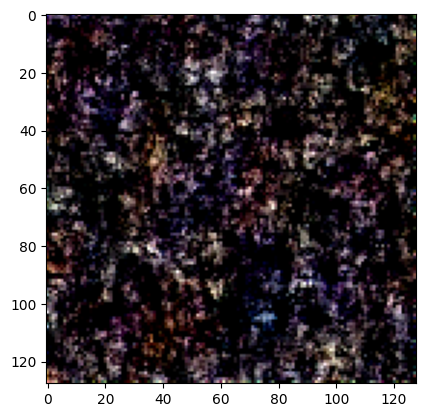

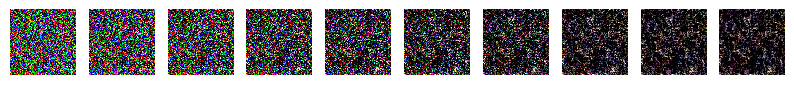

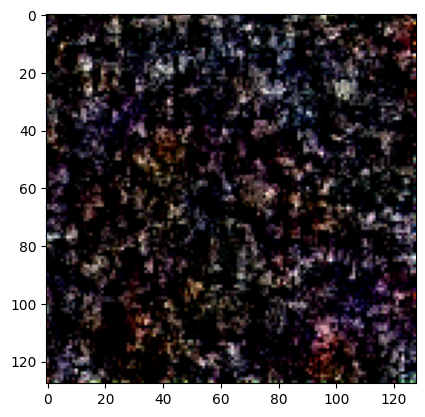

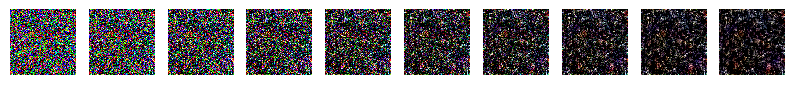

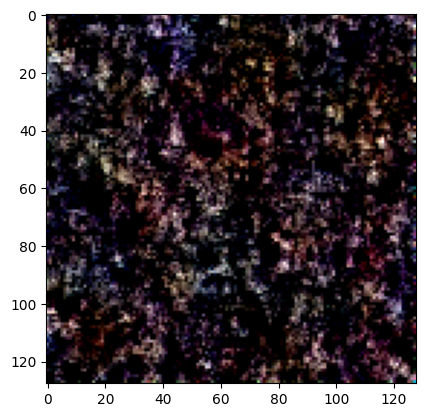

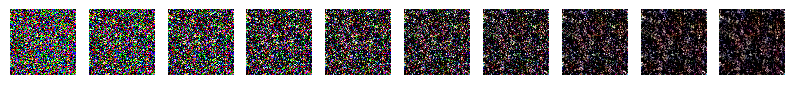

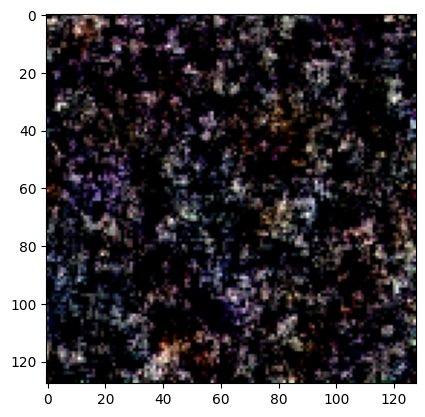

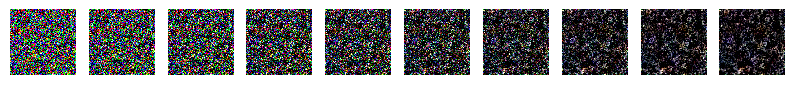

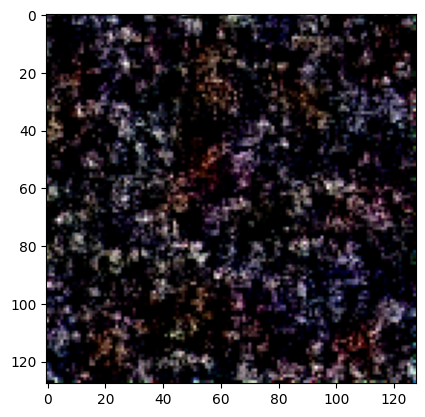

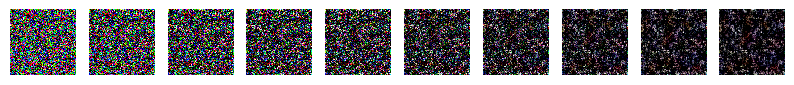

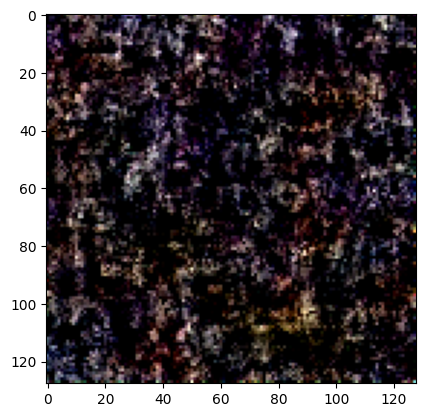

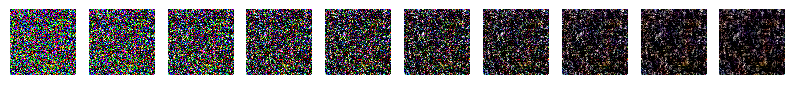

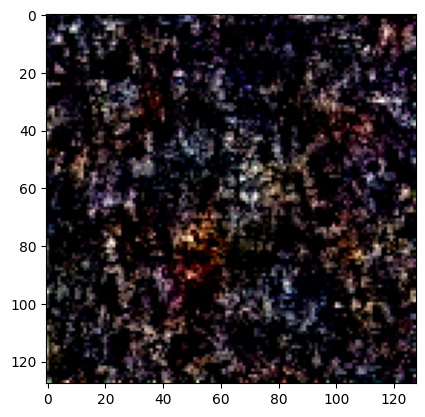

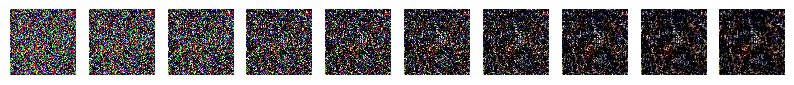

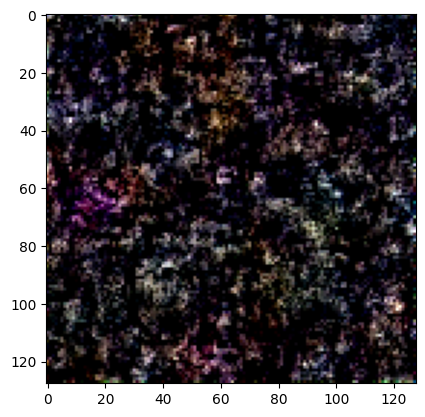

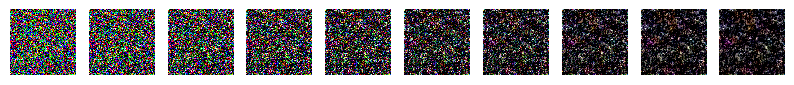

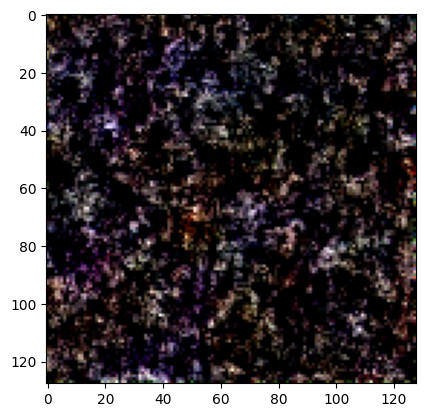

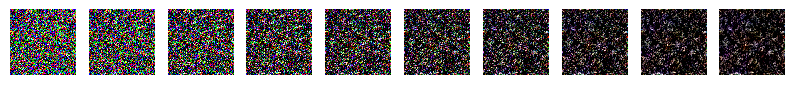

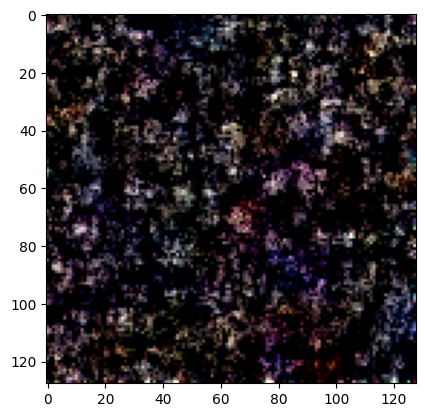

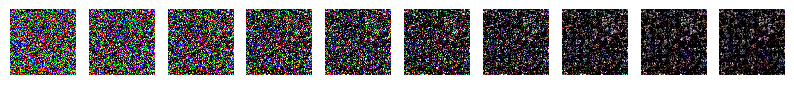

In [11]:
def main():
    train(
        batch_size=2,
        num_epochs=150,
        lr=1e-4
    )

    if os.path.exists("checkpoints/ddpm_small.pt"):
        inference("checkpoints/ddpm_small.pt", num_time_steps=50)
    else:
        print("Checkpoint not found — skipping inference.")


main()